# Final Project

In this paper, we'll look at a couple of different types of autoencoders. The first one is variational autoencoders. This category of autoencoders was introduced by Diederik Kingma and Max Welling (2013) and quickly became one of the most popular types of autoencoders. Variational autoencoders are different from the autoencoders we have seen so far  in two main ways:
1. They are probabilistic autoencoders. This means that even after training, their output is partly determined by chance. As we'll see shortly, VAEs encode the input into a Normal distribution. We then sample from it to decode and get the output, so there is a probabilistic aspect to it.
2. They are generative autoencoders. This means that they can generate new instances that look like they were sampled from the training set

The second type of autoencoder we'll look at is denoising autoencoders. They were introduced by Vincent et al. (2010), and as their name suggests, they can be used to recover original files from noisy inputs.

## Variational Autoencoders

As mentioned earlier, these are probabilistic generative autoencoders that can create new instances that look like they were sampled from the training set. Their structure is, for the most part, similar to the regular stacked autoencoders. The only thing that differs them is that instead of directly producing a coding for a given input, the encoder actually produces a mean encoding vector, $\mu$ and a standard deviation vector, $\sigma$. Since we're dealing with multiple variables, we'll create a multivariate Normal distribution (although a Gaussian distribution is the most popular for different reasons, other distributions can be used as well). This is done using Variational Bayesian Inference by estimating the values of the mean, $\mu$ and the covariance matrix $\Sigma$ that'll be able to approximate the posterior of the distribution in the latent space. In calculating the covariance matrix, we will assume that the covariance between any two variables is 0, so the inputs of the matrix everywhere except the diagonal. We can then represent this as a simple one-dimensional vector since it only holds the variances of the variables. This

After we do the encoding, we then sample from the Normal distribution and then simply feed it to the decoder network, much like we would do for a regular autoencoder. We will then get an output that resembles an example from the training set. Here is an image that'll describe what is going on in the network:

![VAE Image](VAE_Basic.png)

One of the strongest points of VAEs is that once they're trained, getting new images is so easy: sample from the latent Normal distribution, decode it, and you have your new image.

Now that we've seen the basic architecture of VAEs, let's look at the cost function that they use. The cost function is composed of two parts. The first one is the loss function that we've seen in regular autoencoders. It's the reconstruction loss that pushes the autoencoder to reproduce its inputs. The regular cross entropy can be used for this. The second part is the latent loss that pushes the autoencoder to have codings that look like they were sampled from a simple Normal distribution. Enter KL divergenece. KL divergence is a type of statistical distance that measures how far apart two distributions are. The closer the value it is to zero, the more similar the distributions are. Therefore, our latent loss will be the KL divergence between our target distribution (the Gaussian distribution) and the actual distributions of the codings. 


\begin{equation}
LatentLoss = -0.5 \sum_{i=1}^{k} \left(1 + \log{\sigma_i^2} - \sigma_i^2 - \mu_i^2\right)
\end{equation}

where $\mu_i$ and $\sigma_i$ are the mean and standard deviation of the $i^{th}$ component of the codings. 

The vectors $\mu$ and $\sigma$ are outputs of the encoder an dthey contain all the $\mu_i$ and $\sigma_i$. There is also one big adjustment that we have to make here in order for the training to work properly. The variance of a normal distribution is a positive number, but since neural network numbers are naturally unbounded, we transform the variance to map to the whole real number line, $(-\infty,\infty)$. We can use the logairthmic transformation to do this mapping by setting $\gamma=log(\sigma^2)$. The previous euqation for the latent loss will now be updated to:

\begin{equation}
LatentLoss = -0.5 \sum_{i=1}^{k} \left(1 + \gamma_i - exp(\gamma_i) - \mu_i^2\right)
\end{equation}

Before creating the VAE, I'll explain what my data is and what it looks like. The data comes from the [All-Age-Faces dataset](https://github.com/JingchunCheng/All-Age-Faces-Dataset). This dataset contains 13,322 face images of mostly Asian people distributed across all ages (from 2 to 80), including 7381 females and 5941 males. I'll be using this dataset to train a VAE to create faces that are not real people. I'll also be training a denoising autoencoder to be able to reconstruct the original faces from noisy and/or missing ones.

The images are not standardized. Most of them are bigger than 300 pixels in both directions, but the actual number is different from image to image. The images are also color images, so they have values for RGB. I'll standardize the images to 50-by-50-pixel size. I have tried bigger numbers to make the resolution even better, but that will make the training harder and inefficient.

In [173]:
from glob import glob
from PIL import Image
from resizeimage import resizeimage
import numpy as np
import matplotlib.pyplot as plt


# resize and crop images
def get_resized_images(images_file):
    img = []
    # for each image path
    for path in images_file:
    # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # resize the image to be more manageable
                cover = resizeimage.resize_cover(image, [50,50])
                img.append(np.array(cover))

    
    return np.array(img)

In [174]:
# import images and resize them to 50-by-50-pixels

images_file = glob('original images/*')
img = get_resized_images(images_file)
img.shape   # we have 13322 50-by-50-pixel images in RGB

(13322, 50, 50, 3)

Let's see what the first 10 images look like:

Total Images: 10


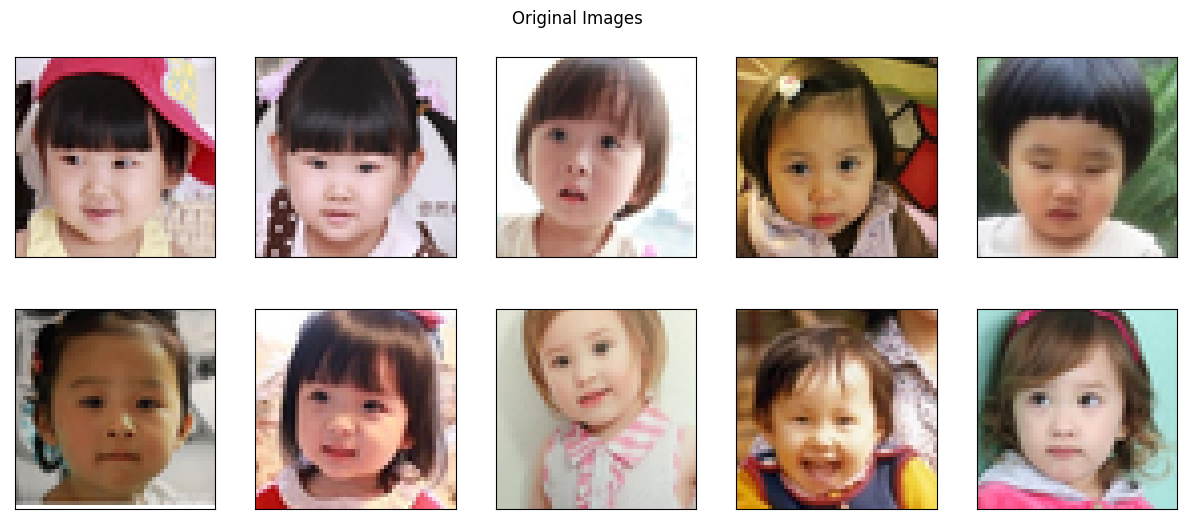

In [175]:
def show_original_images(resized_images):
    # resize images using function
    images = resized_images
    print(f'Total Images: {len(images)}')
    # plot samples of original images
    fig = plt.figure(figsize=(15, 6))
    for i in range(resized_images.shape[0]):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        img = Image.fromarray(images[i].reshape(50,50,3), 'RGB')
        ax.imshow(img, interpolation='nearest')
    plt.suptitle('Original Images', y=0.95)
    plt.show()

show_original_images(img[:10])

We can now start to build our VAE. We will use tensorflow's keras API.

In [194]:
# import the necessary libraries

import tensorflow as tf
from tensorflow import keras

The structure of the encoder consists of an input layer that takes in the 50-by-50-pixel image. We then have two hidden layers connected to the input layer. This is the encoder part of the architecture. It will create a mean and a standard deviation of size 10 (that's what we're reducing our original images into). It will then sample from a Normal distribution given the mean and standard deviation and feed that to the decoder. I'll first provide the code that'll do the sampling and then the encoder network.

In [179]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence


# Helps with sampling from the Normal distribution created by the encoder. We then feed this to the decoder
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs   # use log_var since we want unconstrained values for our neural network
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [180]:
# Create the encoder of the VAE

codings_size = 10   # our latent space (our mean and standard deviation) will have a size of 10

inputs = keras.layers.Input(shape=[50, 50, 3])   # input layer to take in the image
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)  # 2 hidden layers using the 'selu' activation function with decreasing number of neurons
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)   # μ (mean)
codings_log_var = keras.layers.Dense(codings_size)(z)   # γ (log of variance to map it to real numbers)
codings = Sampling()([codings_mean, codings_log_var])   # sample from the Normal distribution
variational_encoder = keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

We can the build the decoder that takes in the sample from the Normal distribution and then passes it through two hidden layers and the final output layer that finally reshapes it to get a color image of new faces

In [181]:
# Build the decoder that takes in a sample from the Normal distribution and decodes it to create a new image

decoder_inputs = keras.layers.Input(shape=[codings_size])   # take in the sample from the Normal distribution
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)  # 2 hidden layers with the 'selu' activation function with increasing number of neurons
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(50 * 50 * 3, activation="sigmoid")(x)
outputs = keras.layers.Reshape([50, 50, 3])(x)   # reshape to get our output
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

We can now call the encoder and get the codings (sample from the Normal distribution). We then pass that to the decoder to get the outputs

In [182]:
_, _, codings = variational_encoder(inputs) 
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])


We then specify how it'll be trained. We use the binary cross entropy loss but we'll also add the latent loss for minimizing the KL divergence. This also mathematically turns out to be the same thing as maximizing the ELBO (Evidence Lower Bound) in Bayesian Variational Inference.

In [183]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

latent_loss = -0.5 * K.sum(
 1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
 axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 2500.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])


We can then finally train our model. Since this is a self-supervised training algorithm, both the features and labels will be the same data. We'll train our model for 30 epochs using a batch size of 128 traning training examples.

In [185]:
history = variational_ae.fit(img/255, img/255, epochs=30, batch_size=128, validation_split=0.1)

Epoch 1/30
94/94 [==============================] - 9s 90ms/step - loss: 0.6027 - rounded_accuracy: 0.7893 - val_loss: 0.5978 - val_rounded_accuracy: 0.8010
Epoch 2/30
94/94 [==============================] - 8s 86ms/step - loss: 0.5984 - rounded_accuracy: 0.7956 - val_loss: 0.5975 - val_rounded_accuracy: 0.7998
Epoch 3/30
94/94 [==============================] - 8s 80ms/step - loss: 0.5941 - rounded_accuracy: 0.8016 - val_loss: 0.5941 - val_rounded_accuracy: 0.8071
Epoch 4/30
94/94 [==============================] - 10s 103ms/step - loss: 0.5919 - rounded_accuracy: 0.8050 - val_loss: 0.5971 - val_rounded_accuracy: 0.8009
Epoch 5/30
94/94 [==============================] - 8s 89ms/step - loss: 0.5897 - rounded_accuracy: 0.8091 - val_loss: 0.5908 - val_rounded_accuracy: 0.8112
Epoch 6/30
94/94 [==============================] - 7s 76ms/step - loss: 0.5883 - rounded_accuracy: 0.8107 - val_loss: 0.6007 - val_rounded_accuracy: 0.7994
Epoch 7/30
94/94 [==============================] - 7s 7

We can now create new faces that did not exist in the original dataset. This can be done by randomly sampling from the Normal distribution created by the encoder and then decoding it. Every time we run the code cell below, we get new faces.

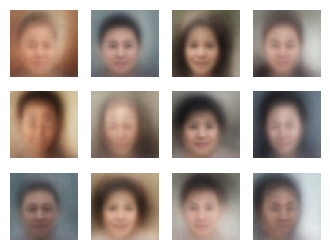

In [189]:
# Generate new images by sampling from the latent space (the Normal distribution created by the variational encoder)

def plot_new_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_new_images(images, 4)

As we can see above, we were able to generate new images of faces that are not in the original dataset. And that's why VAEs are known as generative models, as compared to regular autoencoders. Sites such as [thispersondoesnotexist.com](https://thispersondoesnotexist.com/) use generative models to create new images, but with a higher resolution. There are also other generative models, including generative adversarial networks (GANs), which are composed of two neural networks, a generator, and a discriminator, which are made to compete with each other in a zero-sum game. As a result, GANs are much harder to train, and it’s harder to get them to converge. Therefore, using VAEs is easier and more appropriate in this scenario.

There are also other generative models that are based on diffusion. Programs such as DALL.E 2 and Stable Diffusion work using these diffusion models. These models are different in the sense that they also have a network that can extract the semantic meaning of a sentence and convert it into numerical representation, which is then embedded into the network at different stages. They start off an image and add Gaussian noise to the image and then try to remove it in a sequence of steps. I won't go into detail about how these diffusion algorithms work because it's not the objective of this paper, but understanding how a denoising algorithm works will be beneficial to understand how their inner parts work. Therefore, in the next part, I'll explain how denoising autoencoders work and create one using TensorFlow's keras API.

## Denoising Autoencoders

Much like regular autoencoders, denoising autoencoders also consist of an encoder and a decoder. They are trained in a way that'll allow them to recover original noise-free inputs. There are two main ways to train denoising autoencoders. The first one is to add some noise to our noise-free inputs and feed that to the autoencoder and try to recover the original inputs. This will allow them to learn the basic patterns of the inputs and filter out any noise. The second one is to corrupt the original inputs by dropping some of their pixels or other information. This is then passed to the autoencoder which is tasked to recover the original inputs. The two methods can be visualized as follows:

![Denoising AE Image](Denoising_AE.png)

This class of autoencoders is very useful and can be used in tasks, including the recovery of corrupted files. For example, the problem we saw in class, where the different images from the telescope that were corrupted could potentially be recovered using denoising autoencoders. We can train the denoising autoencoders by feeding them previous uncorrupted images added with a Gaussian noise or using a dropout. The AE will then be able to detect patterns and fill in missing parts and/or filter any noise that might be present in the corrupted images.

The implementation of denoising autoencoders is straightforward. We just use a regular stacked autoencoder with a dropout layer or a Gaussian noise layer before feeding the data to the encoder. Let's first implement the one with a Gaussian noise layer, and then to implement the one with the dropout layer, we can simply just change one line.

In [204]:
# Denoising Autoencoder by adding a Gaussian Noise

codings_size = 10  # the bottleneck layer will have 10 neurons

# create the encoder with two hidden layers
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 50, 3]),
    keras.layers.GaussianNoise(0.2),  # gaussian noise added
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(codings_size, activation="selu")
])

# create the decoder with two hidden layers
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(50 * 50 * 3, activation="sigmoid"),
    keras.layers.Reshape([50, 50, 3])
])

denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])  # connect the decoder and encoder
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(img/255, img/255, epochs=20, batch_size=128, validation_split=0.1)

Epoch 1/20
94/94 [==============================] - 10s 91ms/step - loss: 0.6928 - rounded_accuracy: 0.5152 - val_loss: 0.6916 - val_rounded_accuracy: 0.5322
Epoch 2/20
94/94 [==============================] - 8s 85ms/step - loss: 0.6868 - rounded_accuracy: 0.5695 - val_loss: 0.6811 - val_rounded_accuracy: 0.5945
Epoch 3/20
94/94 [==============================] - 8s 88ms/step - loss: 0.6641 - rounded_accuracy: 0.6503 - val_loss: 0.6558 - val_rounded_accuracy: 0.6557
Epoch 4/20
94/94 [==============================] - 7s 78ms/step - loss: 0.6408 - rounded_accuracy: 0.6922 - val_loss: 0.6466 - val_rounded_accuracy: 0.6652
Epoch 5/20
94/94 [==============================] - 8s 82ms/step - loss: 0.6331 - rounded_accuracy: 0.7018 - val_loss: 0.6391 - val_rounded_accuracy: 0.6817
Epoch 6/20
94/94 [==============================] - 7s 76ms/step - loss: 0.6282 - rounded_accuracy: 0.7098 - val_loss: 0.6355 - val_rounded_accuracy: 0.6911
Epoch 7/20
94/94 [==============================] - 7s 76

Now that we have trained the denoising autoencoder, we can test it by reconstructing images. We'll create a layer of noise, add it to our original images and feed it to the autoencoder to reconstruct the original images

In [217]:
def show_reconstructions(model, images=img, n_images=4):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 191ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


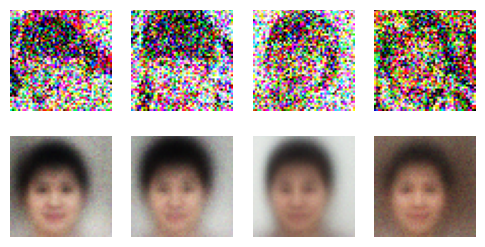

In [218]:
noise = keras.layers.GaussianNoise(0.6)
show_reconstructions(denoising_ae, noise(img/255, training=True))
plt.show()

We can also create a denoising autoencoder with a dropout layer instead of a Gaussian noise layer:

In [210]:
# Denoising Autoencoder using dropout (droping some pixels in the input)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 50, 3]),
    keras.layers.Dropout(0.5),     # use dropout
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(50 * 50 * 3, activation="sigmoid"),
    keras.layers.Reshape([50, 50, 3])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(img/255, img/255, epochs=20, validation_split=0.1)

Epoch 1/20
375/375 [==============================] - 11s 24ms/step - loss: 0.6717 - rounded_accuracy: 0.6087 - val_loss: 0.6469 - val_rounded_accuracy: 0.6670
Epoch 2/20
375/375 [==============================] - 8s 23ms/step - loss: 0.6256 - rounded_accuracy: 0.7170 - val_loss: 0.6252 - val_rounded_accuracy: 0.7232
Epoch 3/20
375/375 [==============================] - 8s 22ms/step - loss: 0.6068 - rounded_accuracy: 0.7560 - val_loss: 0.6077 - val_rounded_accuracy: 0.7590
Epoch 4/20
375/375 [==============================] - 8s 22ms/step - loss: 0.5944 - rounded_accuracy: 0.7805 - val_loss: 0.5986 - val_rounded_accuracy: 0.7753
Epoch 5/20
375/375 [==============================] - 9s 24ms/step - loss: 0.5882 - rounded_accuracy: 0.7924 - val_loss: 0.5914 - val_rounded_accuracy: 0.7893
Epoch 6/20
375/375 [==============================] - 9s 24ms/step - loss: 0.5828 - rounded_accuracy: 0.8021 - val_loss: 0.5804 - val_rounded_accuracy: 0.8114
Epoch 7/20
375/375 [=========================

Now, we can reconstruct some of the images after we corrupt them using a dropout layer:

1/1 [==============================] - 0s 312ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


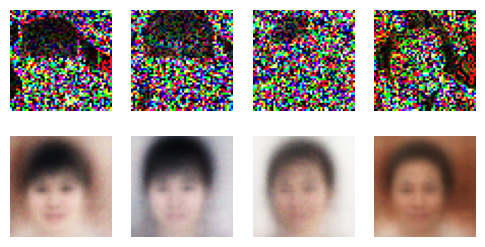

In [219]:
dropout = keras.layers.Dropout(0.6)
show_reconstructions(dropout_ae, dropout(img/255, training=True))
plt.show()

As we can see, the denoising autonecoder was able to fill in the missing pixels from the corrupted image and give us an image that looks like it's from the training set.

### Resources

Kingma, D. P., & Welling, M. (2022). Auto-Encoding Variational Bayes (arXiv:1312.6114). arXiv. https://doi.org/10.48550/arXiv.1312.6114

Vincent, P., Larochelle, H., Lajoie, I., Bengio, Y., & Manzagol, P.-A. (2010). Stacked Denoising Autoencoders: Learning Useful Representations in a Deep Network with a Local Denoising Criterion. Journal of Machine Learning Research, 11(110), 3371–3408. http://jmlr.org/papers/v11/vincent10a.html